# Cluster Lens Simulation Interface

This notebook shows the current progress in the group and cluster scale simulations.

Implemented:
* NFWCluster deflector class: a NFW halo and subhalos that can be any deflector, accesible through the Deflector interface
* Integration with Lens interface to simulate lens related quanities.

Not (yet) implemented:
* Draw halo and subhalo population
* Catalog of cluster halos and cluster members
* Integration with LensPop

## Setup

In [1]:
from slsim.Deflectors.deflector import Deflector
from slsim.lens import Lens
from slsim.lens_pop import LensPop

from astropy.cosmology import FlatLambdaCDM

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
from astropy import units as u
from lenstronomy.Util import param_util
from scipy.spatial.distance import cdist

from matplotlib.patches import Ellipse

# to simulate the resulting lens
import copy
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.DES import DES
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.Plots.plot_util import scale_bar
from astropy.visualization import ZScaleInterval

Generate a population of sources and elliptical deflectors

In [2]:
np.random.seed(0)

In [3]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = u.Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 26, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 26, "z_min": 0.1, "z_max": 5.0}

# run skypy pipeline and make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_type="elliptical",
    source_type="galaxies",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    cosmo=cosmo,
)

This is for visualization

In [4]:
# Instrument setting from pre-defined configurations

DES_g = DES(band="g", psf_type="GAUSSIAN", coadd_years=3)
DES_r = DES(band="r", psf_type="GAUSSIAN", coadd_years=3)
DES_i = DES(band="i", psf_type="GAUSSIAN", coadd_years=3)
des = [DES_g, DES_r, DES_i]

LSST_g = LSST(band="g", psf_type="GAUSSIAN", coadd_years=10)
LSST_r = LSST(band="r", psf_type="GAUSSIAN", coadd_years=10)
LSST_i = LSST(band="i", psf_type="GAUSSIAN", coadd_years=10)
lsst = [LSST_g, LSST_r, LSST_i]

Roman_g = Roman(band="F062", psf_type="PIXEL", survey_mode="wide_area")
Roman_r = Roman(band="F106", psf_type="PIXEL", survey_mode="wide_area")
Roman_i = Roman(band="F184", psf_type="PIXEL", survey_mode="wide_area")
roman = [Roman_g, Roman_r, Roman_i]

In [5]:
def make_zscale_rgb(r, g, b, **kwargs):
    zscale = ZScaleInterval(**kwargs)
    rmin, rmax = zscale.get_limits(r)
    gmin, gmax = zscale.get_limits(g)
    bmin, bmax = zscale.get_limits(b)
    rgb = np.dstack(
        (
            (r - rmin) / (rmax - rmin),
            (g - gmin) / (gmax - gmin),
            (b - bmin) / (bmax - bmin),
        )
    )
    rgb = np.clip(rgb, 0, 1)
    rgb = (rgb * 255.999).astype(np.uint8)
    return rgb

In [6]:
numpix = 200  # number of pixels per axis of the image to be modelled

# here we define the numerical options used in the ImSim module.
# Have a look at the ImageNumerics class for detailed descriptions.
# If not further specified, the default settings are used.
kwargs_numerics = {}


def simulate_rgb(ConfigList, size, kwargs_numerics, contrast=0.1):
    band_b, band_g, band_r = ConfigList
    kwargs_b_band = band_b.kwargs_single_band()
    kwargs_g_band = band_g.kwargs_single_band()
    kwargs_r_band = band_r.kwargs_single_band()

    # set number of pixels from pixel scale
    pixel_scale = kwargs_g_band["pixel_scale"]
    numpix = int(round(size / pixel_scale))

    sim_b = SimAPI(
        numpix=numpix, kwargs_single_band=kwargs_b_band, kwargs_model=kwargs_model
    )
    sim_g = SimAPI(
        numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model
    )
    sim_r = SimAPI(
        numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model
    )

    # return the ImSim instance. With this class instance, you can compute all the
    # modelling accessible of the core modules. See class documentation and other notebooks.
    imSim_b = sim_b.image_model_class(kwargs_numerics)
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)

    # turn magnitude kwargs into lenstronomy kwargs
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_b.magnitude2amplitude(
        kwargs_lens_light_mag_g, kwargs_source_mag_g
    )
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_g.magnitude2amplitude(
        kwargs_lens_light_mag_r, kwargs_source_mag_r
    )
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_r.magnitude2amplitude(
        kwargs_lens_light_mag_i, kwargs_source_mag_i
    )

    image_b = imSim_b.image(
        lenstronomy_kwargs["kwargs_lens"],
        kwargs_source_g,
        kwargs_lens_light_g,
        kwargs_ps_g,
    )
    image_g = imSim_g.image(
        lenstronomy_kwargs["kwargs_lens"],
        kwargs_source_r,
        kwargs_lens_light_r,
        kwargs_ps_r,
    )
    image_r = imSim_r.image(
        lenstronomy_kwargs["kwargs_lens"],
        kwargs_source_i,
        kwargs_lens_light_i,
        kwargs_ps_i,
    )

    # add noise
    image_b += sim_b.noise_for_model(model=image_b)
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)

    img = make_zscale_rgb(image_r, image_g, image_b, contrast=contrast)
    data_class = sim_b.data_class
    return img, data_class

## Basic Example

This example shows the implemented features. It generates a lens from an slsim sampled source, and a halo + subhalos with manually set parameters. It is not intended to be a realistic cluster.

Set seed for reproduction

In [7]:
np.random.seed(3)

Halo parameters:

In [8]:
halo_dict = {
    "halo_mass": 1e14,
    "concentration": 5,
    "e1_mass": 0.1,
    "e2_mass": -0.1,
    "z": 0.42,
}

A random sample of deflectors as subhalos:

In [9]:
subhalos_table = Table.read("../tests/TestData/subhalos_table.fits")
subhalos_table

z,M,coeff,ellipticity,physical_size,stellar_mass,angular_size,mag_g,mag_r,mag_i,mag_z,mag_Y,vel_disp,e1_light,e2_light,e1_mass,e2_mass,n_sersic,center_x,center_y
,,,,kpc,,rad,,,,,,,,,,,,,
float64,float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.40961161750606623,-17.74659351948313,0.014461312431650886 .. 0.0017553671438891554,0.2910638099896307,0.6126468465532885,6134707325.985248,5.449207115062017e-07,24.980052525073667,23.595940832611404,23.07059085953089,22.76766104854414,22.57663477819682,238.6881226614444,-0.04528497553751,0.1416914374289071,-0.0019891604503226743,0.026829555556416532,4.0,2.1991997927160987,3.919514530899428
0.4116468964498543,-21.33484897934431,0.23285635798664925 .. 0.0006941668698218637,0.15174652869004476,3.7017292439367973,240837649679.1357,3.282729405263374e-06,21.567499195041215,20.026445329337342,19.363187222380752,18.981620021271375,18.75254269621525,275.0041773084429,-0.05236187054892784,0.05551789525462122,-0.06511420472541432,0.08282581103144096,4.0,0.8693181053414824,0.8279203242106586
0.357742197708797,-17.70016474314204,0.11749415182192821 .. 0.0009963705918894985,0.09247542465242468,0.22517235412009645,8172885735.947244,2.1789243925349325e-07,24.558320753535146,23.174654552345824,22.60350168788489,22.273007291380058,22.085215345311457,239.48534781261813,0.023416486644143208,0.03998480716073247,0.08818194961203064,0.2393539252201014,4.0,-1.4313058824457068,-1.2971386999655654
0.43321408312382476,-21.624890597703676,0.08464660764530811 .. 0.0009006445161237372,0.21060142972690385,2.3919434702572593,260035388352.9656,2.058095711291011e-06,21.000557844900243,19.926803223244768,19.33049856621807,19.010991686213686,18.79413875740036,276.91021844529143,0.10590581383265181,0.011186271676403,0.01235901177287892,0.0008661401605979852,4.0,0.5913335287465081,9.373582206571212
0.40664485199633355,-20.323923719919286,0.04239681022192635 .. 0.000642978918452646,0.3224955343138368,1.4049504867155502,82384629856.09811,1.2551227098076372e-06,22.470274300452132,20.990325400071697,20.39528372488079,20.065144547510236,19.87646729406098,256.2982137470725,-0.029037278604714677,0.1631091572224996,-0.01927975004064865,0.10069437796471338,4.0,7.369516112011384,5.00295994058848
0.4376178752381092,-18.7936006252479,0.14206729280250247 .. 0.0016625409960951707,0.1647023203467217,0.4254001095167009,20230857612.75885,3.6388064941698217e-07,24.21872306092851,22.799104546193014,22.146352378632578,21.79395982665163,21.565756843217763,243.85574045984882,-0.0754136386484834,0.03446838704341557,-0.018110945492180335,0.008948504939325357,4.0,-5.005510169566389,-2.681860992222449
0.4099796727538578,-16.512141575263364,0.030875540197497997 .. 0.0002203614733351139,0.08513893600336805,0.11686325540198512,2792649800.8751807,1.038882899755727e-07,26.39549320727873,24.83029836517223,24.182210285777888,23.840503093758993,23.65161860291757,236.99130742917959,-0.0424965956722835,0.003577249480990931,0.09694801706010811,-0.017100807340409214,4.0,7.644046541105355,9.268773948886318
0.4127768279274331,-15.721344032029277,0.07559942601411682 .. 0.00027449606564557876,0.26668668280998875,0.2985039673322858,1283273119.2410483,2.642817163990263e-07,27.04262960934578,25.65013657080857,25.022279241903632,24.68099549945051,24.48110194359954,235.93973169995965,-0.0382039211203908,0.1303179954461028,-0.016311796145999414,0.07570778350877454,4.0,16.833942804162128,-6.2521801083342154


In [10]:
subhalos_list = [
    Deflector(deflector_type="EPL", deflector_dict=subhalo)
    for subhalo in subhalos_table
]
len(subhalos_list)

10

Initialize a ClusterLens object to combine the components into a Lenstronomy model.

Draw sources until find a valid lens

In [11]:
max_try = 100
i = 0
while i < max_try:
    source_dict = gg_lens_pop._sources.draw_source()

    cluster_lens = Lens(
        source_dict=source_dict,
        deflector_dict=halo_dict,
        deflector_kwargs={"subhalos_list": subhalos_list},
        deflector_type="NFW_CLUSTER",
        lens_equation_solver="lenstronomy_default",
        cosmo=cosmo,
    )
    i += 1
    if cluster_lens.validity_test(max_image_separation=50.0):
        print("valid!")
        break

valid!


In [12]:
cluster_lens.einstein_radius_deflector

16.814567035135138

In [13]:
lenstronomy_components, lenstronomy_kwargs = cluster_lens.lenstronomy_kwargs(band="g")

Visualize the result

In [14]:
# g-band
kwargs_source_mag_g = lenstronomy_kwargs["kwargs_source"]
kwargs_lens_light_mag_g = lenstronomy_kwargs["kwargs_lens_light"]

# r-band
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_r[i]["magnitude"] = subhalos_table[i]["mag_r"]

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]["magnitude"] = source_dict["mag_r"]

# i-band
kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_i[i]["magnitude"] = subhalos_table[i]["mag_i"]

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]["magnitude"] = source_dict["mag_i"]

Use Lenstronomy sim API to visualize the result

In [15]:
kwargs_model = {
    "lens_model_list": lenstronomy_components[
        "lens_model_list"
    ],  # list of lens models to be used
    "lens_light_model_list": lenstronomy_components[
        "lens_light_model_list"
    ],  # list of unlensed light models to be used
    "source_light_model_list": lenstronomy_components[
        "source_light_model_list"
    ],  # list of extended source models to be used, here we used the interpolated real galaxy
}

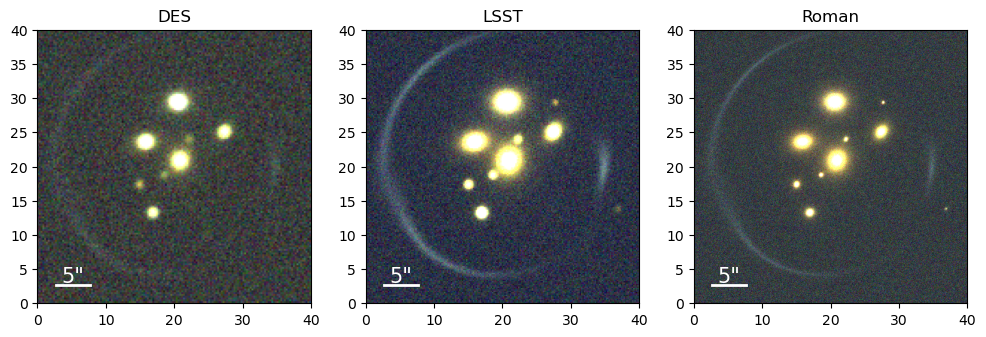

In [16]:
size = 40.0  # width of the image in units of arc seconds

img_des, coords_des = simulate_rgb(
    des, size=size, kwargs_numerics=kwargs_numerics, contrast=0.15
)
img_lsst, coords_lss = simulate_rgb(
    lsst, size=size, kwargs_numerics=kwargs_numerics, contrast=0.15
)
img_roman, coords_roman = simulate_rgb(
    roman, size=size, kwargs_numerics=kwargs_numerics, contrast=0.15
)

f, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.imshow(img_des, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("DES")
# coordinate_arrows(ax, d=1, coords=coords_des, color='w', font_size=15, arrow_size=0.05)
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)

ax = axes[1]
ax.imshow(img_lsst, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("LSST")
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)

ax = axes[2]
ax.imshow(img_roman, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("Roman")
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)
plt.show()

## Example drawing redMaPPer cluster

Draw a cluster from DES redMaPPer catalog and assign an slsim deflector for each cluster member and a cluster-sized halo based in scaling relations.

This feature is not yet implemented in slsim, but is a possible way of making realistic cluster lenses.

Set seed for reproduction

In [17]:
np.random.seed(1)

redMaPPer cluster catalog

In [18]:
clusters = Table.read("../data/redMaPPer/clusters.fits")
members = Table.read("../data/redMaPPer/members.fits")

Draw a cluster as an example

In [19]:
cluster_id = np.random.choice(clusters["ID"])
cluster_data = clusters[clusters["ID"] == cluster_id][0]
members_data = members[members["ID"] == cluster_id]
members_data.sort("R")  # sort by distance to the center

In [20]:
_bcgs_ids = [cluster_data[f"ID{i}"] for i in range(4)]
_bcgs_iprobs = [cluster_data[f"PCen{i}"] for i in range(4)]
_bcgs_iprobs = np.array(_bcgs_iprobs) / np.sum(_bcgs_iprobs)
bcg_id = np.random.choice(_bcgs_ids, p=_bcgs_iprobs)
bcg_data = members_data[members_data["ObjID"] == bcg_id]

In [21]:
members_data["center_x"] = (members_data["RAJ2000"] - bcg_data["RAJ2000"]) * u.deg.to(
    u.arcsec
)
members_data["center_y"] = (members_data["DEJ2000"] - bcg_data["DEJ2000"]) * u.deg.to(
    u.arcsec
)

In [22]:
members_data = members_data[
    "ID", "ObjID", "PMem", "R", "center_x", "center_y", "gmag", "rmag", "imag", "zmag"
]
members_data.rename_columns(
    ["gmag", "rmag", "imag", "zmag"], ["mag_g", "mag_r", "mag_i", "mag_z"]
)

Draw some deflectors

In [23]:
n_deflectors = 5000
deflectors_table = []
for _ in range(n_deflectors):
    deflectors_table.append(gg_lens_pop._lens_galaxies.draw_deflector())
deflectors_table = vstack(deflectors_table)

Assign a deflector for each cluster member based on magnitude and color

In [24]:
def assing_similar_deflector(
    members_table, deflectors_table, cluster_z, cosmo=None, bands=("g", "r", "i", "z")
):
    mag_members = [members_table[f"mag_{b}"].data for b in bands]
    mag_deflectors = [deflectors_table[f"mag_{b}"].data for b in bands]
    dist_mod_members = (
        -5
        * np.log10(cosmo.luminosity_distance(cluster_z) / (10 * u.pc))
        * np.ones(len(members_table))
    )
    dist_mod_deflectors = -5 * np.log10(
        cosmo.luminosity_distance(deflectors_table["z"].data) / (10 * u.pc)
    )
    distance = cdist(
        np.stack([*mag_members, dist_mod_members], axis=1),
        np.stack([*mag_deflectors, dist_mod_deflectors], axis=1),
        metric="euclidean",
    )
    nearest_neighbors_indices = distance.argmin(axis=1)
    similar_deflectors = deflectors_table[nearest_neighbors_indices]
    return similar_deflectors

In [25]:
subhalos_table = assing_similar_deflector(
    members_data,
    deflectors_table,
    cluster_data["zlambda"],
    cosmo=cosmo,
    bands=("g", "r", "i", "z"),
)
subhalos_table = hstack(
    [subhalos_table, members_data["ID", "ObjID", "PMem", "center_x", "center_y"]]
)

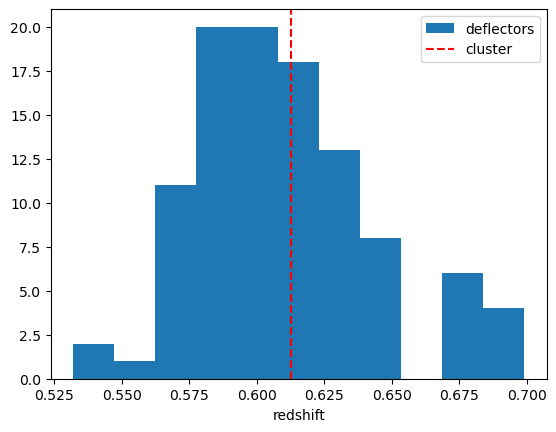

In [26]:
plt.hist(subhalos_table["z"], bins="auto", label="deflectors")
plt.axvline(cluster_data["zlambda"], c="r", ls="--", label="cluster")
plt.xlabel("redshift")
plt.legend()
plt.show()

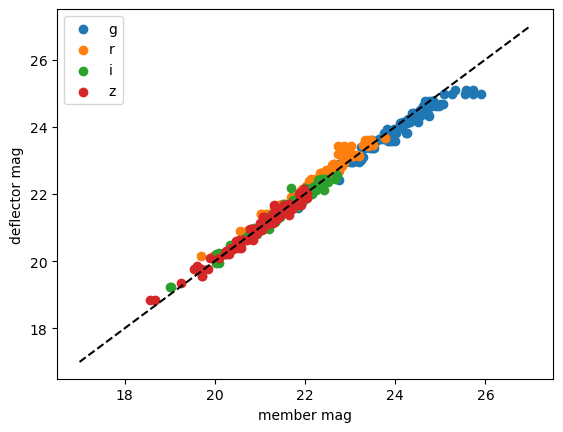

In [27]:
plt.scatter(members_data["mag_g"], subhalos_table["mag_g"], label="g")
plt.scatter(members_data["mag_r"], subhalos_table["mag_r"], label="r")
plt.scatter(members_data["mag_i"], subhalos_table["mag_i"], label="i")
plt.scatter(members_data["mag_z"], subhalos_table["mag_z"], label="z")
plt.plot(np.linspace(17, 27), np.linspace(17, 27), "k--")
plt.xlabel("member mag")
plt.ylabel("deflector mag")
plt.legend()
plt.show()

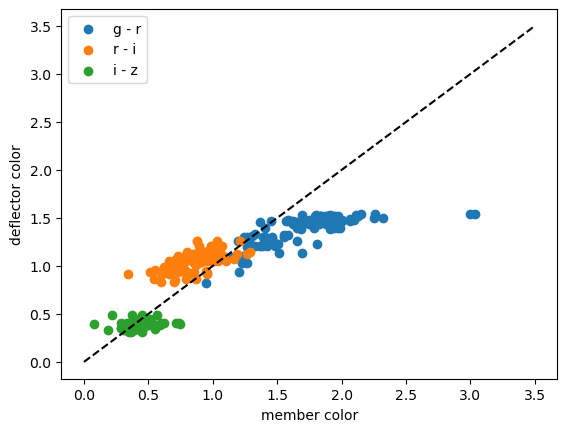

In [28]:
plt.scatter(
    members_data["mag_g"] - members_data["mag_r"],
    subhalos_table["mag_g"] - subhalos_table["mag_r"],
    label="g - r",
)
plt.scatter(
    members_data["mag_r"] - members_data["mag_i"],
    subhalos_table["mag_r"] - subhalos_table["mag_i"],
    label="r - i",
)
plt.scatter(
    members_data["mag_i"] - members_data["mag_z"],
    subhalos_table["mag_i"] - subhalos_table["mag_z"],
    label="i - z",
)
plt.plot(np.linspace(0, 3.5), np.linspace(0, 3.5), "k--")
plt.xlabel("member color")
plt.ylabel("deflector color")
plt.legend()
plt.show()

We have to assign a halo to the cluster. By now we set the halo mass and concentration by hand, the ellipticity is chosen based on the distribution of the subhalos.

Set the halo ellipticity from subhalo distribution, weighted by stellar mass:

In [29]:
cov_matrix = np.cov(
    np.stack([subhalos_table["center_x"], subhalos_table["center_y"]], axis=1),
    aweights=subhalos_table["stellar_mass"],
    rowvar=False,
)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
largest_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
phi = np.arctan2(largest_eigenvector[1], largest_eigenvector[0])
q = np.sqrt(np.min(eigenvalues) / np.max(eigenvalues))
e1, e2 = param_util.phi_q2_ellipticity(phi, q)

Visualize the members distribution, along with an ellipse describing the shape of the halo

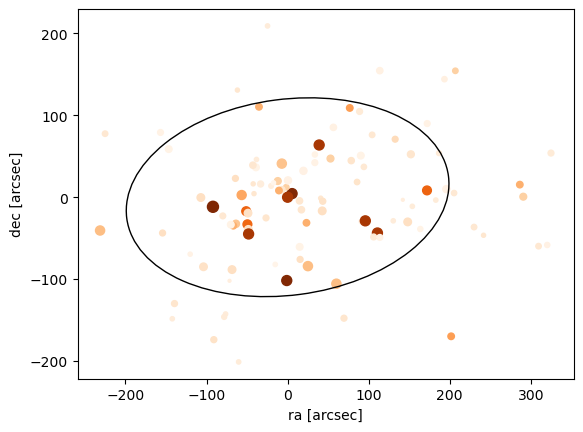

In [30]:
plt.scatter(
    subhalos_table["center_x"],
    subhalos_table["center_y"],
    s=subhalos_table["physical_size"] * 10,
    c=subhalos_table["stellar_mass"],
    cmap="Oranges",
)
plt.gca().add_patch(
    Ellipse(
        (0, 0), 400, 400 * q, angle=np.rad2deg(phi), facecolor="none", edgecolor="k"
    )
)
plt.xlabel("ra [arcsec]")
plt.ylabel("dec [arcsec]")
plt.show()

Halo NFW parameters, the mass and concetration are arbitrary:

In [31]:
halo_dict = {
    "halo_mass": 4e14,  # TODO: assign mass based on halo mass function + mass-richness relation
    "concentration": 5,  # TODO: set concentration from mass-redshift-concentration relation
    "e1_mass": e1,
    "e2_mass": e2,
    "z": cluster_data["zlambda"],
}

for k, v in halo_dict.items():
    print(f"{k}: {v:1.2e}")

halo_mass: 4.00e+14
concentration: 5.00e+00
e1_mass: 2.43e-01
e2_mass: 6.41e-02
z: 6.13e-01


Initialize the subhalos as deflectors

In [32]:
subhalos_list = [
    Deflector(deflector_type="EPL", deflector_dict=subhalo)
    for subhalo in subhalos_table
]
len(subhalos_list)

103

Initialize a ClusterLens object to combine the components into a Lenstronomy model.

Draw sources until find a valid lens

In [33]:
max_try = 100
i = 0
while i < max_try:
    source_dict = gg_lens_pop._sources.draw_source()

    cluster_lens = Lens(
        source_dict=source_dict,
        deflector_dict=halo_dict,
        deflector_kwargs={"subhalos_list": subhalos_list},
        deflector_type="NFW_CLUSTER",
        lens_equation_solver="lenstronomy_default",
        cosmo=cosmo,
    )
    i += 1
    if cluster_lens.validity_test(max_image_separation=50.0):
        print("valid!")
        break
assert cluster_lens.validity_test(max_image_separation=50.0)

valid!


In [34]:
cluster_lens.einstein_radius_deflector

8.478270104494491

In [35]:
lenstronomy_components, lenstronomy_kwargs = cluster_lens.lenstronomy_kwargs(band="g")

Visualize the result

In [36]:
# g-band
kwargs_source_mag_g = lenstronomy_kwargs["kwargs_source"]
kwargs_lens_light_mag_g = lenstronomy_kwargs["kwargs_lens_light"]

# r-band
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_r[i]["magnitude"] = subhalos_table[i]["mag_r"]

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]["magnitude"] = source_dict["mag_r"]

# i-band
kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
for i in range(len(kwargs_lens_light_mag_r)):
    kwargs_lens_light_mag_i[i]["magnitude"] = subhalos_table[i]["mag_i"]

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]["magnitude"] = source_dict["mag_i"]

Use Lenstronomy sim API to visualize the result

In [37]:
kwargs_model = {
    "lens_model_list": lenstronomy_components[
        "lens_model_list"
    ],  # list of lens models to be used
    "lens_light_model_list": lenstronomy_components[
        "lens_light_model_list"
    ],  # list of unlensed light models to be used
    "source_light_model_list": lenstronomy_components[
        "source_light_model_list"
    ],  # list of extended source models to be used, here we used the interpolated real galaxy
}

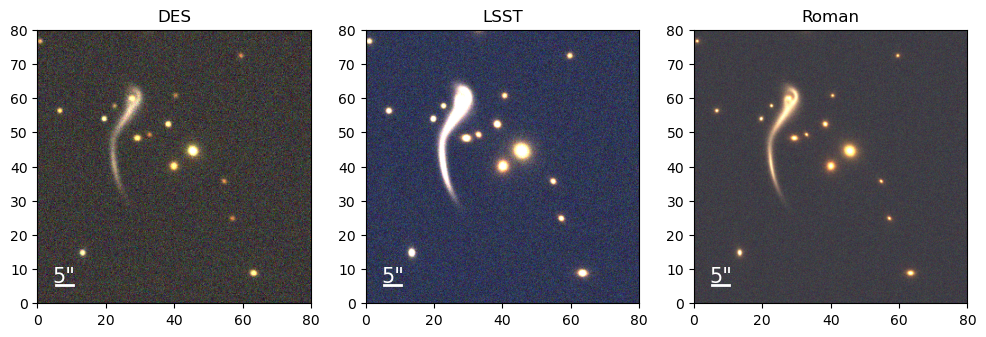

In [38]:
size = 80.0  # width of the image in units of arc seconds

img_des, coords_des = simulate_rgb(
    des, size=size, kwargs_numerics=kwargs_numerics, contrast=0.15
)
img_lsst, coords_lss = simulate_rgb(
    lsst, size=size, kwargs_numerics=kwargs_numerics, contrast=0.15
)
img_roman, coords_roman = simulate_rgb(
    roman, size=size, kwargs_numerics=kwargs_numerics, contrast=0.15
)

f, axes = plt.subplots(1, 3, figsize=(12, 4))

ax = axes[0]
ax.imshow(img_des, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("DES")
# coordinate_arrows(ax, d=1, coords=coords_des, color='w', font_size=15, arrow_size=0.05)
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)

ax = axes[1]
ax.imshow(img_lsst, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("LSST")
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)

ax = axes[2]
ax.imshow(img_roman, aspect="equal", origin="lower", extent=[0, size, 0, size])
ax.set_title("Roman")
scale_bar(ax, d=size, dist=5.0, text='5"', color="w", font_size=15, flipped=False)
plt.show()